# [GD-6]WEAT_Score

In [1]:
import os
from konlpy.tag import Okt
from gensim.models import Word2Vec

## 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [5]:
# synopsis.txt 파일을 읽어 품사가 명사인 경우만 남겨 tokenized라는 변수명으로 저장
# 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

okt = Okt()
tokenized = []   # corpus 저장

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ['Noun']:
                res.append(w[0])   # 명사일 때만 tokenized 에 저장
        tokenized.append(res)

In [6]:
print(len(tokenized))

71156


## 2. 추출된 결과로 embedding model 만들기

In [7]:
# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

[('작품', 0.8882182836532593),
 ('다큐멘터리', 0.8479589223861694),
 ('드라마', 0.8166401982307434),
 ('영화로', 0.8008851408958435),
 ('코미디', 0.7971516251564026),
 ('형식', 0.7790593504905701),
 ('소재', 0.7664041519165039),
 ('실화', 0.7628978490829468),
 ('감동', 0.7616081237792969),
 ('주제', 0.7614166140556335)]

In [8]:
model.wv.most_similar(positive=['사랑'])

[('행복', 0.7022679448127747),
 ('첫사랑', 0.6980181336402893),
 ('우정', 0.6931626200675964),
 ('진심', 0.6852931380271912),
 ('애정', 0.6847073435783386),
 ('운명', 0.6835036873817444),
 ('시빌라', 0.6785563230514526),
 ('고백', 0.6730458736419678),
 ('감정', 0.6696271300315857),
 ('비랄', 0.6679853796958923)]

## 3. target, attribute 단어 셋 만들기

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread:
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline()
            if not line: break
            tokenlist = okt.pos(line, stem=True, norm=True)
            for word in tokenlist:
                if word[1] in ["Noun"]:
                    result.append((word[0]))
    return ' '.join(result)

In [13]:
art = read_token(art_txt)   # 예술 영화
gen = read_token(gen_txt)   # 일반 영화

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [14]:
art[:100]

'사운드 엔지니어 상우 유지태 분 치매 할머니 백성희 분 시절 상처 아버지 박인환 분 고모 신신애 분 살 겨울 그 지방 방송국 라디오 은수 이영애 분 를 자연 소리 채집 라디오 프로'

In [15]:
gen[:100]

'유사 연령 성별 빈부 차이 정치 입장 불문 국민 통합 온 애국심 성역 일침 다큐멘터리 재작년 전국 민족 민주 유가족 협의 회의 장기 농성 인상 다큐멘터리 민들레 를 독립영화 집단 '

In [16]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [17]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [19]:
# 양쪽에 중복된 단어가 너무 많음
# 단어가 서로 중복되지 않게 단어셋을 추출해야함
# 두 개념축이 대조되도록 대표하는 단어 셋을 만들어야함
# 우선 상위 100개의 단어들 중 중복되는 단어를 제외하고 상위 n(=15)개의 단어를 추출

n = 15
w1_, w2_ = [], []

for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])
    
# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): 
        target_art.append(w1_[i])
        
    if len(target_art) == n:
        break

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): 
        target_gen.append(w2_[i])
        
    if len(target_gen) == n: 
        break

In [20]:
len(w1_), len(w2_)

(100, 100)

In [22]:
print(target_art)
print(target_gen)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']
['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


In [23]:
# 장르별 대표 단어를 추출
# 여러 장르의 코퍼스를 두루 고려하는 것이 특정 장르를 대표하는 단어를 선택하는 데 더 유리

genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [24]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [25]:
len(genre)

21

In [26]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [27]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

## 4. WEAT score 계산과 시각화

In [29]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [30]:
def cos_sim(i, j):
    return dot(i, j.T) / (norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B

def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)   # x의 편향
    s_Y = s(Y, A, B)   # y의 편향 
    
    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return (mean_X - mean_Y) / std_dev

In [28]:
# 구한 결과를 21x21 매트릭스 형태로 표현해서 matrix 라는 변수에 담기
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [32]:
A = np.array([model.wv[word] for word in target_art])
B = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        X = np.array([model.wv[word] for word in attributes[i]])
        Y = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [33]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] > 1.1 or matrix[i][j] < -1.1:
            print(genre_name[i],genre_name[j],matrix[i][j])

SF 멜로로맨스 -1.338969
공포(호러) 다큐멘터리 1.1688006
기타 멜로로맨스 -1.1774896
다큐멘터리 멜로로맨스 -1.4823194
다큐멘터리 미스터리 -1.2854381
다큐멘터리 성인물(에로) -1.2373786
다큐멘터리 스릴러 -1.1698737
멜로로맨스 범죄 1.2328557
멜로로맨스 서부극(웨스턴) 1.1749864
멜로로맨스 애니메이션 1.1721095
멜로로맨스 전쟁 1.4387172
미스터리 전쟁 1.1080371


### 시각화

<AxesSubplot:>

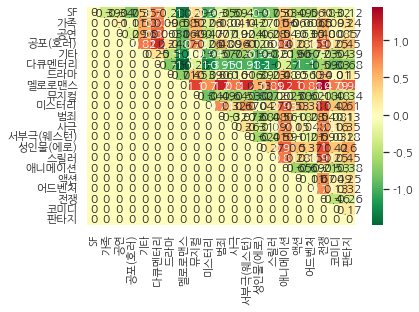

In [36]:
import numpy as np; 
import seaborn as sns; 
import matplotlib.pyplot as plt

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')
# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

<AxesSubplot:>

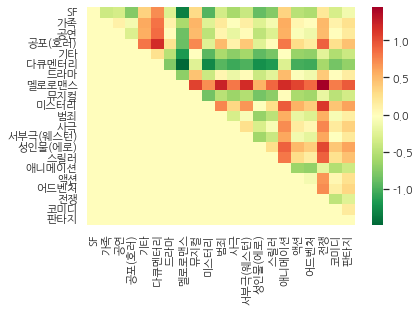

In [37]:
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, cmap='RdYlGn_r')
ax

# 회고

* '편향성'이란 단어가 잘 와닿지 않았다. 국어사전 뜻으로는 '한쪽으로 치우친 성질'인데 이번 노드에서는 단순히 뜻으로만 이해하기는 어려움이 있다고 생각했다.  
* 변환된 워드 임베딩(word embedding) 간의 거리를 이용해 해당 데이터셋의 편향 정도를 측정할 수 있다.
* 이번 프로젝트에서 예술영화와 일반영화로 나누는 기준이 모호하다 생각하므로 정확한 결과가 아니라 생각한다.
* 그렇지만 편향성이란 것이 존재한다는 것과 이것을 측정하는 방법이 있다는 것을 알게되었다.
* 히트맵 결과를 보면 멜로로맨스와 전쟁이 가장 진하게 나타났다.

# 참고 사이트

[참고깃허브주소](https://github.com/miinkang/AI_Project_AIFFEL/blob/main/%5BGD-06%5Dword_embedding_association_WEAT.ipynb)